# Module 5: Auditing and Evaluating LLM Performance
- Metric 1: Headline rank difference between LLM-generated and expert-written headlines
- Metric 2: Top 3/5 recall rate from LLM and expert selections
- Metric 3: Average rank of LLM and expert selections

Define the date range to evaluate LLM performance.

In [ ]:
#### EDIT THIS
WEEKS = [
    ("20250331", "20250404"),
    ("20250407", "20250411"),
    ("20250414", "20250418"),
    ("20250421", "20250425")
]
#### EDIT THIS

## Metric 1: Headline rank difference
Computes and displays the average rank difference between LLM generated headlines and expert written headlines, for the same controlled topics.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

The folder `_interim/headlines/` should contain a `.csv` file of all headlines for each week. The rankings used are the LLM-generated and expert-written headlines ranked together by human evaluators. These are in the three folders:
- `_interim/rankings/claude_manual/`
- `_interim/rankings/gemini_manual/`
- `_interim/rankings/openai_manual/`

The figures will be saved to the folder `results/`.

In [5]:
HEADLINES_PATH = Path("../_interim/headlines/")
assert HEADLINES_PATH.exists()
CLAUDE_MANUAL_RANKING_PATH = Path("../_interim/rankings/claude_manual/")
assert CLAUDE_MANUAL_RANKING_PATH.exists()
GEMINI_MANUAL_RANKING_PATH = Path("../_interim/rankings/gemini_manual/")
assert GEMINI_MANUAL_RANKING_PATH.exists()
OPENAI_MANUAL_RANKING_PATH = Path("../_interim/rankings/openai_manual/")
assert OPENAI_MANUAL_RANKING_PATH.exists()
RESULTS_PATH = Path("../results/")
assert RESULTS_PATH.exists()


Compute and display average rank displacements.

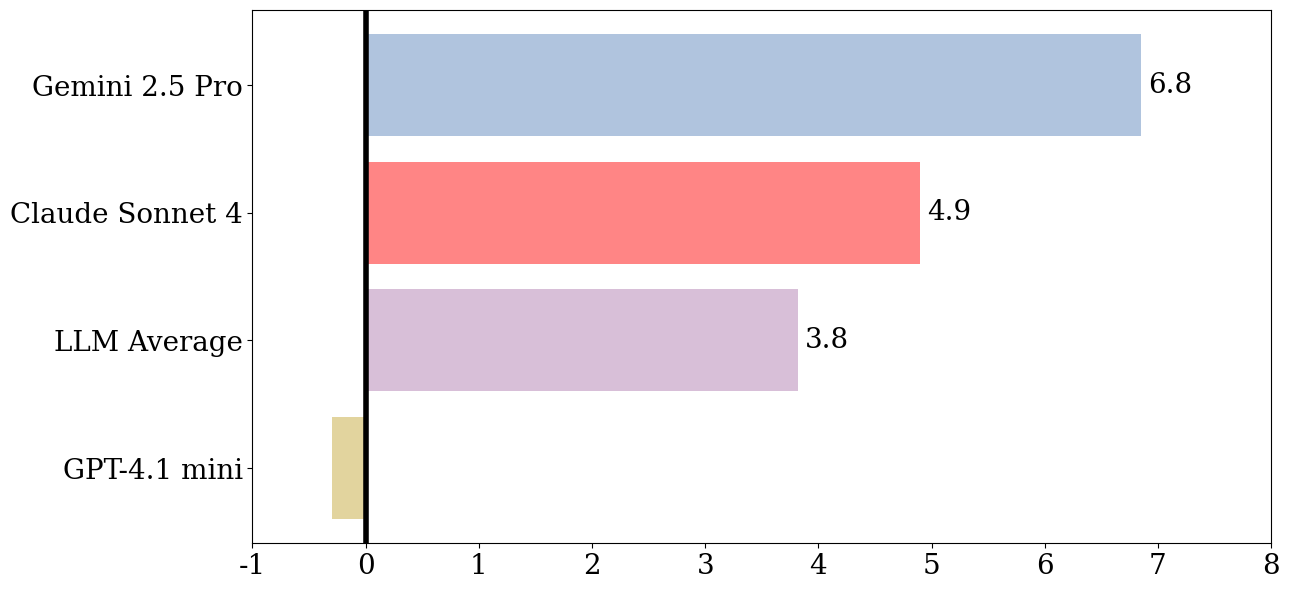

In [ ]:
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False
})

llms = ["claude", "gemini", "openai"]
llm_to_abbrev = {"claude": "C", "gemini": "G", "openai": "O"}
llm_to_manual_folder = {"claude": CLAUDE_MANUAL_RANKING_PATH,
                        "gemini": GEMINI_MANUAL_RANKING_PATH,
                        "openai": OPENAI_MANUAL_RANKING_PATH}

# displacement tracking
displacements = {llm: 0 for llm in llms}
counts = {llm: 0 for llm in llms}

# process each week
for week in WEEKS:
    week_str = f"{week[0]}_{week[1]}"
    df = pd.read_csv(HEADLINES_PATH / f"{week_str}.csv")
    manual_indices = [idx for idx, row in df.iterrows() if row["manual_headline"] != "NO_HEADLINE"]

    # load rankings for each LLM
    rankings = {
        llm: pd.read_csv(llm_to_manual_folder[llm] / f"{week_str}.csv")
        for llm in llms
    }

    # compare ranks for each manual headline
    for llm in llms:
        abbrev = llm_to_abbrev[llm]
        ranking = rankings[llm]

        for mi in manual_indices:
            manual_label = f"M{mi}"
            llm_label = f"{abbrev}{mi}"

            manual_rank = ranking.loc[ranking["label"] == manual_label, "rank"].values[0]
            llm_rank = ranking.loc[ranking["label"] == llm_label, "rank"].values[0]
            displacement = manual_rank - llm_rank

            displacements[llm] += displacement
            counts[llm] += 1

# average displacement calculations
avg_displacements = {
    llm: displacements[llm] / counts[llm] for llm in llms
}
overall_avg = sum(displacements.values()) / sum(counts.values())


data = {
    'Claude Sonnet 4': avg_displacements["claude"],
    'Gemini 2.5 Pro': avg_displacements["gemini"],
    'GPT-4.1 mini': avg_displacements["openai"],
    'LLM Average': overall_avg
}

# sort bars from highest to lowest
sorted_items = sorted(data.items(), key=lambda x: x[1])
labels, values = zip(*sorted_items)

# bar colors
color_map = {
    'Claude Sonnet 4': "#FF8585",
    'Gemini 2.5 Pro': "#B0C4DE",
    'GPT-4.1 mini': "#E2D49E",
    'LLM Average': "#D8BFD8"
}
colors = [color_map[label] for label in labels]

# plot graph
fig, ax = plt.subplots(figsize=(13, 6))
bars = ax.barh(labels, values, color=colors)

ax.axvline(0, color='black', linewidth=4)
ax.set_xlim(-1, 8)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', labelsize=20)

# annotate bars
for bar in bars:
    width = bar.get_width()
    ax.annotate(
        f'{width:.1f}',
        xy=(width, bar.get_y() + bar.get_height() / 2),
        xytext=(5 if width > 0 else -5, 0),
        textcoords='offset points',
        ha='left' if width > 0 else 'right',
        va='center',
        fontsize=20,
        color='white' if width < 0 else 'black'
    )

plt.tight_layout()
plt.savefig(RESULTS_PATH / "headline_rank_difference.pdf")
# plt.savefig(RESULTS_PATH / "headline_rank_difference.png")

## Metric 2: Top-3/5 recall rate from LLM and expert selections
Computes and displays the average recall rate of the true top-3 and true top-5 topics covered by the LLM and expert selections.

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The folder `_interim/headlines/` should contain a `.csv` file of all headlines for each week. The true top-3 and true top-5 topics are obtained from the corresponding isolated LLM-generated headlines ranked by human evaluators. These are in the three folders:
- `_interim/rankings/claude_only/`
- `_interim/rankings/gemini_only/`
- `_interim/rankings/openai_only/`

The LLM's selection of topics is obtained from the corresponding folders:
- `_interim/rankings/claude_ranks_claude/`
- `_interim/rankings/claude_ranks_gemini/`
- `_interim/rankings/claude_ranks_openai/`
- `_interim/rankings/gemini_ranks_claude/`
- `_interim/rankings/gemini_ranks_gemini/`
- `_interim/rankings/gemini_ranks_openai/`
- `_interim/rankings/openai_ranks_claude/`
- `_interim/rankings/openai_ranks_gemini/`
- `_interim/rankings/openai_ranks_openai/`

The figures will be saved to the folder `results/`.

In [18]:
HEADLINES_PATH = Path("../_interim/headlines/")
assert HEADLINES_PATH.exists()
CLAUDE_ONLY_RANKING_PATH = Path("../_interim/rankings/claude_only/")
assert CLAUDE_ONLY_RANKING_PATH.exists()
GEMINI_ONLY_RANKING_PATH = Path("../_interim/rankings/gemini_only/")
assert GEMINI_ONLY_RANKING_PATH.exists()
OPENAI_ONLY_RANKING_PATH = Path("../_interim/rankings/openai_only/")
assert OPENAI_ONLY_RANKING_PATH.exists()

CLAUDE_RANKS_CLAUDE_PATH = Path("../_interim/rankings/claude_ranks_claude/")
assert CLAUDE_RANKS_CLAUDE_PATH.exists()
CLAUDE_RANKS_GEMINI_PATH = Path("../_interim/rankings/claude_ranks_gemini/")
assert CLAUDE_RANKS_GEMINI_PATH.exists()
CLAUDE_RANKS_OPENAI_PATH = Path("../_interim/rankings/claude_ranks_openai/")
assert CLAUDE_RANKS_OPENAI_PATH.exists()

GEMINI_RANKS_CLAUDE_PATH = Path("../_interim/rankings/gemini_ranks_claude/")
assert GEMINI_RANKS_CLAUDE_PATH.exists()
GEMINI_RANKS_GEMINI_PATH = Path("../_interim/rankings/gemini_ranks_gemini/")
assert GEMINI_RANKS_GEMINI_PATH.exists()
GEMINI_RANKS_OPENAI_PATH = Path("../_interim/rankings/gemini_ranks_openai/")
assert GEMINI_RANKS_OPENAI_PATH.exists()

OPENAI_RANKS_CLAUDE_PATH = Path("../_interim/rankings/openai_ranks_claude/")
assert OPENAI_RANKS_CLAUDE_PATH.exists()
OPENAI_RANKS_GEMINI_PATH = Path("../_interim/rankings/openai_ranks_gemini/")
assert OPENAI_RANKS_GEMINI_PATH.exists()
OPENAI_RANKS_OPENAI_PATH = Path("../_interim/rankings/openai_ranks_openai/")
assert OPENAI_RANKS_OPENAI_PATH.exists()

RESULTS_PATH = Path("../results/")
assert RESULTS_PATH.exists()


Load in some variables and settings.

In [19]:
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False
})


llms = ["claude", "gemini", "openai"]
llm_to_abbrev = {"claude": "C", "gemini": "G", "openai": "O"}
llm_to_only_folder = {"claude": CLAUDE_ONLY_RANKING_PATH,
                      "gemini": GEMINI_ONLY_RANKING_PATH,
                      "openai": OPENAI_ONLY_RANKING_PATH}
judge_rank_folder = {("claude", "claude"): CLAUDE_RANKS_CLAUDE_PATH,
                     ("claude", "gemini"): CLAUDE_RANKS_GEMINI_PATH,
                     ("claude", "openai"): CLAUDE_RANKS_OPENAI_PATH,
                     ("gemini", "claude"): GEMINI_RANKS_CLAUDE_PATH,
                     ("gemini", "gemini"): GEMINI_RANKS_GEMINI_PATH,
                     ("gemini", "openai"): GEMINI_RANKS_OPENAI_PATH,
                     ("openai", "claude"): OPENAI_RANKS_CLAUDE_PATH,
                     ("openai", "gemini"): OPENAI_RANKS_GEMINI_PATH,
                     ("openai", "openai"): OPENAI_RANKS_OPENAI_PATH}

Define some helper functions.

In [20]:
def parse_label_ids(labels):
    return set(int(label[1:]) for label in labels)

def load_top_n_labels(week_str, llm, n):
    df = pd.read_csv(llm_to_only_folder[llm] / f"{week_str}.csv")
    return parse_label_ids(df.iloc[:n]["label"])

def load_llm_ranking_indices(week_str, llm, judge, num_manual):
    df = pd.read_csv(judge_rank_folder[(judge, llm)] / f"{week_str}.csv")
    return parse_label_ids(df.iloc[:num_manual]["label"])

Compute and display the recall rates.

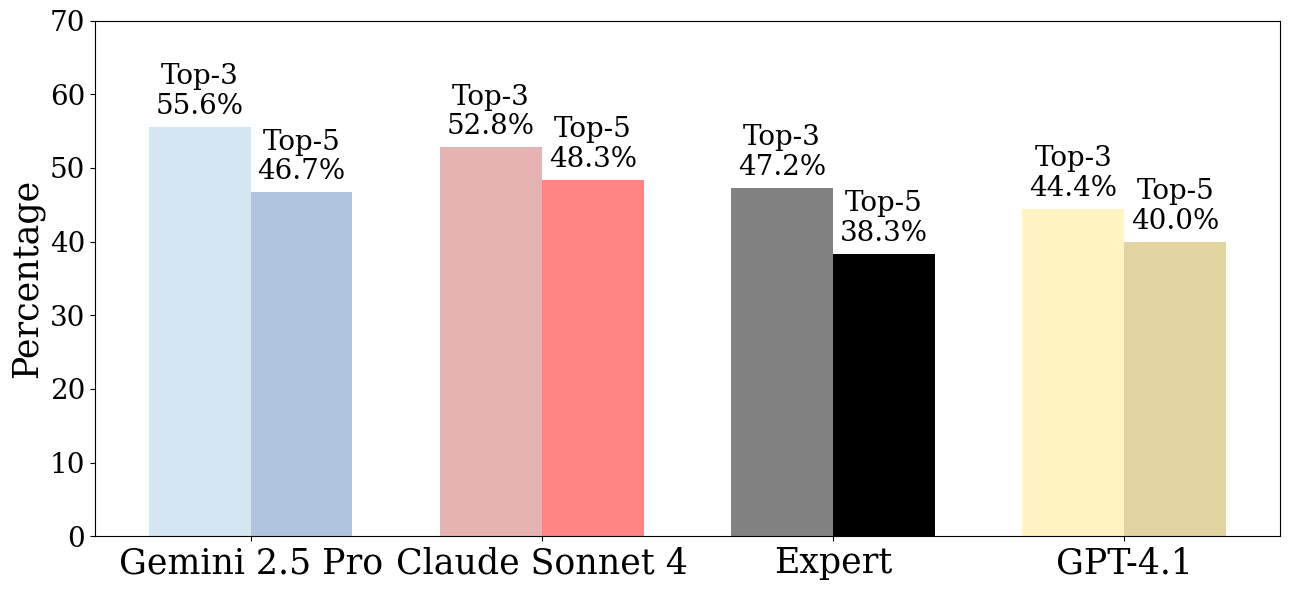

In [ ]:
# recall counters
recall = {
    "manual_top3": 0,
    "manual_top5": 0,
    "claude_top3": 0,
    "claude_top5": 0,
    "gemini_top3": 0,
    "gemini_top5": 0,
    "openai_top3": 0,
    "openai_top5": 0
}



# process each week
for week_start, week_end in WEEKS:
    week_str = f"{week_start}_{week_end}"


    df = pd.read_csv(HEADLINES_PATH / f"{week_str}.csv")
    manual_indices = set(df[df["manual_headline"] != "NO_HEADLINE"].index)

    # load top-3 and top-5 for each LLM
    top3 = {llm: load_top_n_labels(week_str, llm, 3) for llm in llms}
    top5 = {llm: load_top_n_labels(week_str, llm, 5) for llm in llms}

    # count overlap with manual
    recall["manual_top3"] += sum(len(top3[llm] & manual_indices) for llm in llms)
    recall["manual_top5"] += sum(len(top5[llm] & manual_indices) for llm in llms)

    # load LLM rankings judged by each LLM
    num_manual = len(manual_indices)
    for judge in llms:
        judge_key_top3 = f"{judge}_top3"
        judge_key_top5 = f"{judge}_top5"
        for llm in llms:
            pred_indices = load_llm_ranking_indices(week_str, llm, judge, num_manual)
            recall[judge_key_top3] += len(top3[llm] & pred_indices)
            recall[judge_key_top5] += len(top5[llm] & pred_indices)




# normalize recall values
num_weeks = len(WEEKS)
for key in recall:
    if "top3" in key:
        recall[key] /= (num_weeks * 3)
    elif "top5" in key:
        recall[key] /= (num_weeks * 5)




# plot the graph
group_labels = ['Gemini 2.5 Pro', 'Claude Sonnet 4', 'Expert', 'GPT-4.1']
values_top3 = [
    100 * recall["gemini_top3"] / 3,
    100 * recall["claude_top3"] / 3,
    100 * recall["manual_top3"] / 3,
    100 * recall["openai_top3"] / 3
]
values_top5 = [
    100 * recall["gemini_top5"] / 3,
    100 * recall["claude_top5"] / 3,
    100 * recall["manual_top5"] / 3,
    100 * recall["openai_top5"] / 3
]

x = np.arange(len(group_labels))
width = 0.35


# colors
color_top3 = {
    'Claude Sonnet 4': "#E6B3B3",
    'Gemini 2.5 Pro': "#D4E6F1",
    'GPT-4.1': "#FFF4C2",
    'Expert': "#828282"
}
color_top5 = {
    'Claude Sonnet 4': "#FF8585",
    'Gemini 2.5 Pro' : "#B0C4DE",
    'GPT-4.1': "#E2D49E",
    'Expert': "#000000"
}

fig, ax = plt.subplots(figsize=(13, 6))
bars_top3 = ax.bar(x - width/2, values_top3, width, color=[color_top3[g] for g in group_labels])
bars_top5 = ax.bar(x + width/2, values_top5, width, color=[color_top5[g] for g in group_labels])

ax.set_ylim(0, 70)
ax.set_ylabel('Percentage', fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(group_labels, fontsize=25)
ax.tick_params(axis='y', labelsize=20)

# bar annotations
def annotate_bars(bars, label):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=20)
        ax.text(bar.get_x() + bar.get_width() / 2, height + 5, label,
                ha='center', va='bottom', fontsize=20)

annotate_bars(bars_top3, "Top-3")
annotate_bars(bars_top5, "Top-5")

plt.tight_layout()
plt.savefig(RESULTS_PATH / "recall_rate.pdf")
# plt.savefig(RESULTS_PATH / "recall_rate.png")

## Metric 3: Average rank of LLM and expert selections

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

The folder `_interim/headlines/` should contain a `.csv` file of all headlines for each week. The true rank of topics are obtained from the corresponding isolated LLM-generated headlines ranked by human evaluators. These are in the three folders:
- `_interim/rankings/claude_only/`
- `_interim/rankings/gemini_only/`
- `_interim/rankings/openai_only/`

The LLM's selection of topics is obtained from the corresponding folders:
- `_interim/rankings/claude_ranks_claude/`
- `_interim/rankings/claude_ranks_gemini/`
- `_interim/rankings/claude_ranks_openai/`
- `_interim/rankings/gemini_ranks_claude/`
- `_interim/rankings/gemini_ranks_gemini/`
- `_interim/rankings/gemini_ranks_openai/`
- `_interim/rankings/openai_ranks_claude/`
- `_interim/rankings/openai_ranks_gemini/`
- `_interim/rankings/openai_ranks_openai/`

The figures will be saved to the folder `results/`.

In [24]:
HEADLINES_PATH = Path("../_interim/headlines/")
assert HEADLINES_PATH.exists()
CLAUDE_ONLY_RANKING_PATH = Path("../_interim/rankings/claude_only/")
assert CLAUDE_ONLY_RANKING_PATH.exists()
GEMINI_ONLY_RANKING_PATH = Path("../_interim/rankings/gemini_only/")
assert GEMINI_ONLY_RANKING_PATH.exists()
OPENAI_ONLY_RANKING_PATH = Path("../_interim/rankings/openai_only/")
assert OPENAI_ONLY_RANKING_PATH.exists()

CLAUDE_RANKS_CLAUDE_PATH = Path("../_interim/rankings/claude_ranks_claude/")
assert CLAUDE_RANKS_CLAUDE_PATH.exists()
CLAUDE_RANKS_GEMINI_PATH = Path("../_interim/rankings/claude_ranks_gemini/")
assert CLAUDE_RANKS_GEMINI_PATH.exists()
CLAUDE_RANKS_OPENAI_PATH = Path("../_interim/rankings/claude_ranks_openai/")
assert CLAUDE_RANKS_OPENAI_PATH.exists()

GEMINI_RANKS_CLAUDE_PATH = Path("../_interim/rankings/gemini_ranks_claude/")
assert GEMINI_RANKS_CLAUDE_PATH.exists()
GEMINI_RANKS_GEMINI_PATH = Path("../_interim/rankings/gemini_ranks_gemini/")
assert GEMINI_RANKS_GEMINI_PATH.exists()
GEMINI_RANKS_OPENAI_PATH = Path("../_interim/rankings/gemini_ranks_openai/")
assert GEMINI_RANKS_OPENAI_PATH.exists()

OPENAI_RANKS_CLAUDE_PATH = Path("../_interim/rankings/openai_ranks_claude/")
assert OPENAI_RANKS_CLAUDE_PATH.exists()
OPENAI_RANKS_GEMINI_PATH = Path("../_interim/rankings/openai_ranks_gemini/")
assert OPENAI_RANKS_GEMINI_PATH.exists()
OPENAI_RANKS_OPENAI_PATH = Path("../_interim/rankings/openai_ranks_openai/")
assert OPENAI_RANKS_OPENAI_PATH.exists()

RESULTS_PATH = Path("../results/")
assert RESULTS_PATH.exists()


Load some variables and define some settings.

In [25]:
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False
})

llms = ["claude", "gemini", "openai"]
llm_to_abbrev = {"claude": "C",
                 "gemini": "G",
                 "openai": "O"}
llm_to_only_folder = {"claude": CLAUDE_ONLY_RANKING_PATH,
                      "gemini": GEMINI_ONLY_RANKING_PATH,
                      "openai": OPENAI_ONLY_RANKING_PATH}
judge_rank_folder = {("claude", "claude"): CLAUDE_RANKS_CLAUDE_PATH,
                     ("claude", "gemini"): CLAUDE_RANKS_GEMINI_PATH,
                     ("claude", "openai"): CLAUDE_RANKS_OPENAI_PATH,
                     ("gemini", "claude"): GEMINI_RANKS_CLAUDE_PATH,
                     ("gemini", "gemini"): GEMINI_RANKS_GEMINI_PATH,
                     ("gemini", "openai"): GEMINI_RANKS_OPENAI_PATH,
                     ("openai", "claude"): OPENAI_RANKS_CLAUDE_PATH,
                     ("openai", "gemini"): OPENAI_RANKS_GEMINI_PATH,
                     ("openai", "openai"): OPENAI_RANKS_OPENAI_PATH}


# initialization
sum_manual_rank = sum_claude_rank = sum_gemini_rank = sum_openai_rank = 0
manual_count = claude_count = gemini_count = openai_count = 0

Compute and display average ranks of topics.

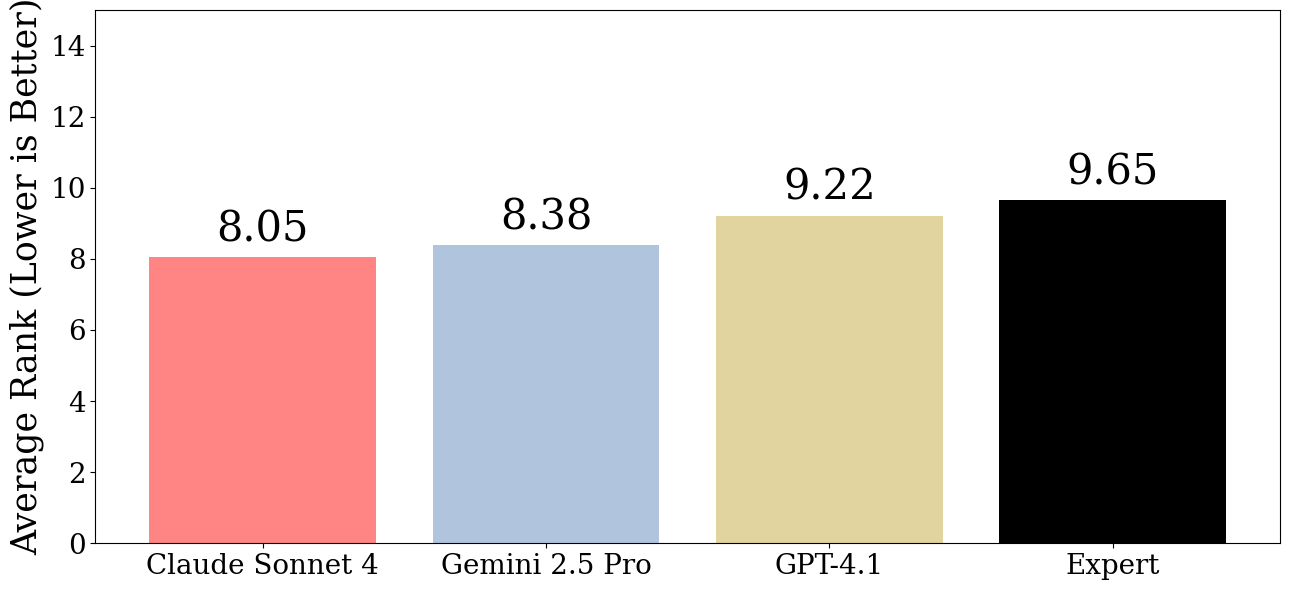

In [ ]:
# process each week
for week in WEEKS:
    week_str = f"{week[0]}_{week[1]}"
    df = pd.read_csv(HEADLINES_PATH / f"{week_str}.csv")
    manual_indices = set(df[df["manual_headline"] != "NO_HEADLINE"].index)

    # load true rankings
    true_df_dict = {
        "true_claude": pd.read_csv(CLAUDE_ONLY_RANKING_PATH / f"{week_str}.csv"),
        "true_gemini": pd.read_csv(GEMINI_ONLY_RANKING_PATH / f"{week_str}.csv"),
        "true_openai": pd.read_csv(OPENAI_ONLY_RANKING_PATH / f"{week_str}.csv")
    }

    # load expert selections
    for gen_llm in llms:
        true = true_df_dict[f"true_{gen_llm}"]
        manual_labels = [f"{llm_to_abbrev[gen_llm]}{i}" for i in manual_indices]

        for _, row in true.iterrows():
            if row["label"] in manual_labels:
                sum_manual_rank += row["rank"]
                manual_count += 1

    # load LLM selections
    for gen_llm in llms:
        for ranking_llm in llms:
            true = true_df_dict[f"true_{gen_llm}"]
            ranking_path = Path(judge_rank_folder[(ranking_llm, gen_llm)] / f"{week_str}.csv")
            ranking = pd.read_csv(ranking_path)

            top_labels = ranking.loc[:len(manual_indices)-1, "label"]

            for _, row in true.iterrows():
                if row["label"] in top_labels.values:
                    if ranking_llm == "claude":
                        sum_claude_rank += row["rank"]
                        claude_count += 1
                    elif ranking_llm == "gemini":
                        sum_gemini_rank += row["rank"]
                        gemini_count += 1
                    elif ranking_llm == "openai":
                        sum_openai_rank += row["rank"]
                        openai_count += 1

# compute averages
avg_manual_rank = sum_manual_rank / manual_count
avg_claude_rank = sum_claude_rank / claude_count
avg_gemini_rank = sum_gemini_rank / gemini_count
avg_openai_rank = sum_openai_rank / openai_count




# plot the graph
rank_data = {
    'Claude Sonnet 4': avg_claude_rank,
    'GPT-4.1': avg_openai_rank,
    'Expert': avg_manual_rank,
    'Gemini 2.5 Pro': avg_gemini_rank
}

# sort results by rank in ascending order
sorted_items = sorted(rank_data.items(), key=lambda x: x[1])
labels, ranks = zip(*sorted_items)

# colors
color_map = {
    'Claude Sonnet 4': "#FF8585",
    'Gemini 2.5 Pro' : "#B0C4DE",
    'GPT-4.1': "#E2D49E",
    'Expert': "#000000"
}
colors = [color_map[label] for label in labels]



fig, ax = plt.subplots(figsize=(13, 6))
bars = ax.bar(labels, ranks, color=colors)

ax.set_ylim(0, 15)
ax.set_ylabel('Average Rank (Lower is Better)', fontsize=25)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

# annotate bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=30)

plt.tight_layout()
plt.savefig(RESULTS_PATH / "average_rank.pdf")
# plt.savefig(RESULTS_PATH / "average_rank.png")

This concludes Module 5: LLM Auditing.